# Problem 1

## Gillespie's Algorithm

### Imports and Helper Functions

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

def standardize_timesteps(data: list[list[float]], data_rate: float, max_t: int) -> np.ndarray:
    t_list = np.array(data[0])
    new_t_list = np.linspace(0, max_t, data_rate * max_t)
    result = np.zeros((len(data), len(new_t_list)))
    result[0] = new_t_list
    for i in range(1, len(data)):
        result[i] = np.interp(new_t_list, t_list, data[i])

    return result

### Classes

In [ ]:
class Population:
    def __init__(self, initial_X, initial_Y, initial_Z):
        self.X = initial_X
        self.Y = initial_Y
        self.Z = initial_Z

    def __str__(self):
        return f"X = {self.X}, Y = {self.Y}, Z = {self.Z}"

    def N(self):
        return self.X + self.Y + self.Z
    
    def tuple(self):
        return (self.X, self.Y, self.Z)

class Gillespie_Parameters:
    def __init__(self, population_size, initial_infected, beta, gamma, mu):
        self.population = Population(population_size - initial_infected, initial_infected, 0)
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.r0 = beta / (gamma + mu)

    def __str__(self):
        return f"r0 = {self.r0:.2f}, beta = {self.beta}, gamma = {self.gamma}, mu = {self.mu}, N = {self.population.N()}"

class Event:
    def __init__(self, name, rate_function, result_function):
        self.name = name
        self.rate_function = rate_function
        self.result_function = result_function

    def get_rate(self, params: Gillespie_Parameters):
        return self.rate_function(params)
    
    def execute_result(self, population: Population):
        return self.result_function(population)

### Define the events

In [ ]:
def _birth_rate(params: Gillespie_Parameters):
    return params.mu * params.population.N()
def _birth_result(pop: Population) -> Population:
    pop.X += 1
BirthEvent = Event('birth', _birth_rate, _birth_result)

def _transmission_rate(params: Gillespie_Parameters):
    return params.beta * params.population.X * params.population.Y / params.population.N()
def _transmission_result(pop: Population) -> Population:
    pop.X -= 1
    pop.Y += 1
TransmissionEvent = Event('transmission', _transmission_rate, _transmission_result)

def _recovery_rate(params: Gillespie_Parameters):
    return params.gamma * params.population.Y
def _recovery_result(pop: Population) -> Population:
    pop.Y -= 1
    pop.Z += 1
RecoveryEvent = Event('recovery', _recovery_rate, _recovery_result)

def _death_x_rate(params: Gillespie_Parameters):
    return params.mu * params.population.X
def _death_x_result(pop: Population) -> Population:
    pop.X -= 1
DeathXEvent = Event('death_x', _death_x_rate, _death_x_result)

def _death_y_rate(params: Gillespie_Parameters):
    return params.mu * params.population.Y
def _death_y_result(pop: Population) -> Population:
    pop.Y -= 1
DeathYEvent = Event('death_y', _death_y_rate, _death_y_result)

def _death_z_rate(params: Gillespie_Parameters):
    return params.mu * params.population.Z
def _death_z_result(pop: Population) -> Population:
    pop.Z -= 1
DeathZEvent = Event('death_z', _death_z_rate, _death_z_result)

events = [BirthEvent, TransmissionEvent, RecoveryEvent, DeathXEvent, DeathYEvent, DeathZEvent]

### Prepare Gillespie Simulation

In [ ]:
class Result:
    def __init__(self, results: np.ndarray):
        self.t = results[0]
        self.X = results[1]
        self.Y = results[2]
        self.Z = results[3]

    def s_i_covariance(self):
        return np.cov(self.X, self.Y)[0][1]

class Results:
    def __init__(self, results: list[Result]):
        if len(results) == 0:
            raise ValueError('Results must have at least one result')
        for r in results:
            if r.t[0] != results[0].t[0]:
                raise ValueError('All results must have the same timesteps')
        self.t = results[0].t
        self.Xs = np.array([r.X for r in results])
        self.Ys = np.array([r.Y for r in results])
        self.Zs = np.array([r.Z for r in results])
    
    def add_result(self, result: Result):
        if result.t[0] != self.t[0]:
            raise ValueError('All results must have the same timesteps')
        self.Xs = np.append(self.Xs, result.X)
        self.Ys = np.append(self.Ys, result.Y)
        self.Zs = np.append(self.Zs, result.Z)

    def mean_result(self):
        return Result(np.array([self.t, np.mean(self.Xs, axis=0), np.mean(self.Ys, axis=0), np.mean(self.Zs, axis=0)]))

    def mean_and_std_infected(self):
        return np.mean(self.Ys, axis=0), np.std(self.Ys, axis=0)
    
    def mean_and_minmax_infected(self):
        minmax = np.zeros((2, len(self.t)))
        minmax[0] = np.min(self.Ys, axis=0)
        minmax[1] = np.max(self.Ys, axis=0)
        return np.mean(self.Ys, axis=0), minmax

def get_rates(events: list[Event], params: Gillespie_Parameters):
    return [e.get_rate(params) for e in events]

def get_delta_ts(rates: list[float]):
    rands = np.random.rand(len(rates))
    while 0 in rands: # avoid zeros
        rands = np.random.rand(len(rates))
    delta_ts = np.full(len(rates), np.inf)
    for i, r in enumerate(rates):
        if r == 0:
            continue
        delta_ts[i] = (-1 / r) * np.log(rands[i])
    return delta_ts


def gillespie(params: Gillespie_Parameters, events: list[Event], t_max) -> list[list[float]]:
    t = 0.0
    params
    results = [[], [], [], []] # t, X, Y, Z
    pop = copy.deepcopy(params.population)
    while t < t_max and params.population.N() > 0:
        y_prev = params.population.Y
        rates = get_rates(events, params)
        delta_ts = get_delta_ts(rates)
        event_index = np.argmin(delta_ts)
        t += delta_ts[event_index]
        events[event_index].execute_result(params.population)
        if params.population.Y == 0 and y_prev != 0:
            print(f'Extinction at t={t}')
        results[0].append(t)
        results[1].append(params.population.X)
        results[2].append(params.population.Y)
        results[3].append(params.population.Z)
    params.population = pop
    return results

class Experiment:
    def __init__(self, params: Gillespie_Parameters, events: list[Event], simulation_length: int, data_rate=1, iterations=1):
        self.params = params
        self.events = events
        self.simulation_length = simulation_length
        self.data_rate = data_rate
        self.iterations = iterations

    def run(self):
        print(f'Running experiment: {str(self.params)}, {self.iterations} iterations')
        self.raw_results = []
        standardized_results = []
        for i in range(self.iterations):
            start = time.perf_counter()
            raw_result = gillespie(self.params, self.events, self.simulation_length)
            self.raw_results.append(raw_result)
            standardized_results.append(Result(standardize_timesteps(raw_result, self.data_rate, self.simulation_length)))
            end = time.perf_counter()
            print(f'Ran iteration {i+1} in {(end - start):.2f} seconds')
        self.results = Results(standardized_results)
        return self.results
    
class Experiments:
    def __init__(self, experiments: list[Experiment]):
        self.experiments = experiments

    def run(self):
        for e in self.experiments:
            e.run()

### Run Gillespie

Running experiment: r0 = 4.55, beta = 0.5, gamma = 0.1, mu = 0.01, N = 10000.0, 1 iterations
Ran iteration 1 in 1.23 seconds


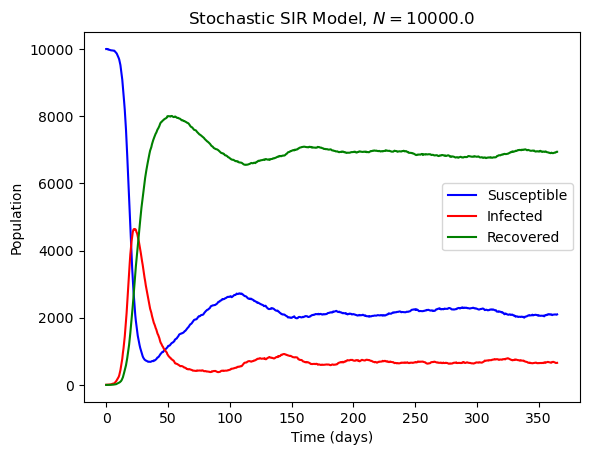

In [67]:
population_size = 1e4
initial_infected = 5
sim_length = 365
data_rate = 2
beta = 0.5
gamma = 0.1
mu = 1/100

experiment1 = Experiment(Gillespie_Parameters(population_size=population_size, initial_infected=initial_infected, beta=beta, gamma=gamma, mu=mu), events=events, simulation_length=sim_length, data_rate=data_rate)

r0 = beta / (gamma + mu)

res = experiment1.run().mean_result()

plt.plot(res.t, res.X, 'b', label='Susceptible')
plt.plot(res.t, res.Y, 'r', label='Infected')
plt.plot(res.t, res.Z, 'g', label='Recovered')
plt.legend(loc='right')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Stochastic SIR Model, $N={population_size}$')
plt.show()

# Compare to deterministic model

Running experiment: r0 = 4.55, beta = 0.5, gamma = 0.1, mu = 0.01, N = 1000.0, 1 iterations
Ran iteration 1 in 0.12 seconds
Running experiment: r0 = 4.55, beta = 0.5, gamma = 0.1, mu = 0.01, N = 10000.0, 1 iterations
Ran iteration 1 in 1.24 seconds
Running experiment: r0 = 4.55, beta = 0.5, gamma = 0.1, mu = 0.01, N = 100000.0, 1 iterations
Ran iteration 1 in 12.51 seconds
Running experiment: r0 = 4.55, beta = 0.5, gamma = 0.1, mu = 0.01, N = 1000000.0, 1 iterations
Ran iteration 1 in 122.80 seconds


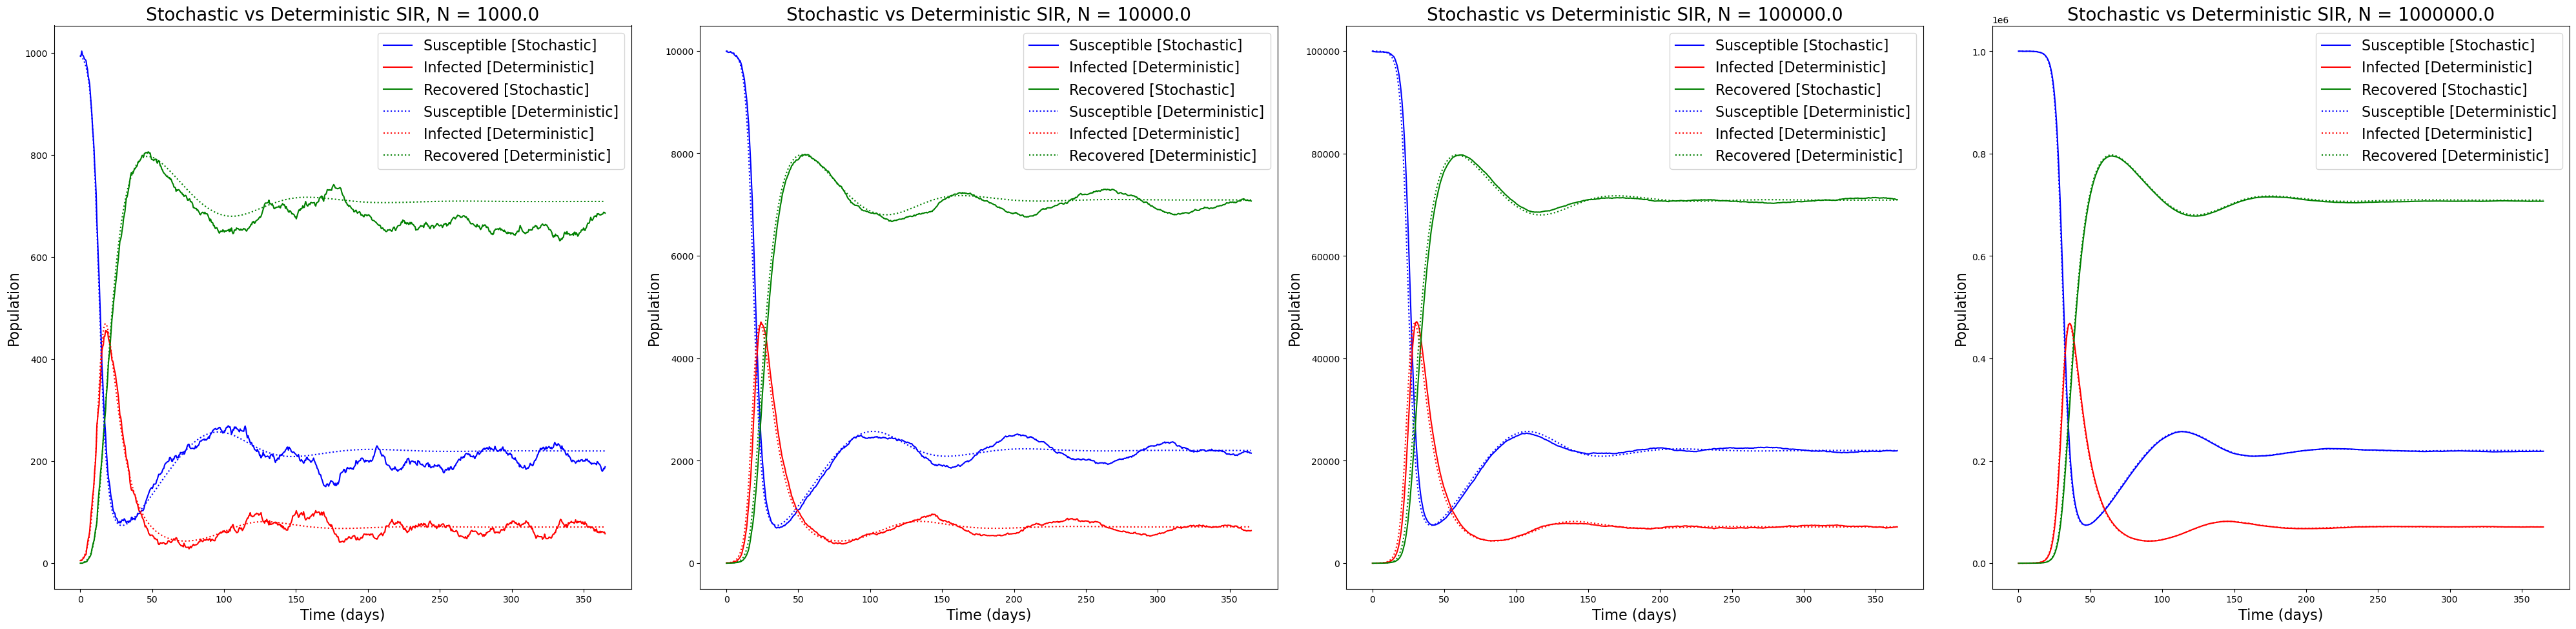

In [68]:
from scipy.integrate import solve_ivp

def deterministic_sir(t, xyz, beta, gamma, mu):
    x, y, z = xyz
    n = x + y + z
    dxdt = mu * n - beta * (x/n) * y - mu * x
    dydt = beta * (x/n) * y - gamma * y - mu * y
    dzdt = gamma * y - mu * z
    return [dxdt, dydt, dzdt]

def integrate_deterministic_sir(experiment: Experiment):
    return solve_ivp(
        deterministic_sir,
        (0, experiment.simulation_length),
        experiment.params.population.tuple(),
        t_eval=np.linspace(0, experiment.simulation_length, experiment.simulation_length * experiment.data_rate),
        args=(experiment.params.beta, experiment.params.gamma, experiment.params.mu))

ns = [1e3, 1e4, 1e5, 1e6]
fig, ax = plt.subplots(1, 4, figsize=(40, 10))
for i, n in enumerate(ns):
    params = Gillespie_Parameters(population_size=n, initial_infected=initial_infected, beta=0.5, gamma=0.1, mu=0.01)
    experiment = Experiment(params, events, sim_length, data_rate=data_rate)
    res = experiment.run().mean_result()
    sol = integrate_deterministic_sir(experiment)

    ax[i].plot(res.t, res.X, 'b', label='Susceptible [Stochastic]')
    ax[i].plot(res.t, res.Y, 'r', label='Infected [Deterministic]')
    ax[i].plot(res.t, res.Z, 'g', label='Recovered [Stochastic]')
    ax[i].plot(sol.t, sol.y[0], 'b:', label='Susceptible [Deterministic]')
    ax[i].plot(sol.t, sol.y[1], 'r:', label='Infected [Deterministic]')
    ax[i].plot(sol.t, sol.y[2], 'g:', label='Recovered [Deterministic]')
    ax[i].legend(fontsize=16)
    ax[i].set_title(f'Stochastic vs Deterministic SIR, N = {n}', fontsize=20)
    ax[i].set_xlabel('Time (days)', fontsize=16)
    ax[i].set_ylabel('Population', fontsize=16)

plt.tight_layout()
plt.show()

## Vary Gillespie parameters

### Vary $R_0$ 

In [79]:
r0s = np.arange(0.5, 15.5, 0.5)
iterations = 5

r0experiments = Experiments([])
for r0 in r0s:
    r0experiments.experiments.append(Experiment(Gillespie_Parameters(population_size, initial_infected, beta=r0 * (gamma + mu), gamma=gamma, mu=mu), events, sim_length, data_rate, iterations))
r0experiments.run()

Running experiment: r0 = 0.50, beta = 0.055, gamma = 0.1, mu = 0.01, N = 10000.0, 5 iterations
Extinction at t=40.40898808633603
Ran iteration 1 in 0.56 seconds
Extinction at t=53.39147730238011
Ran iteration 2 in 0.56 seconds
Extinction at t=25.159991034992757
Ran iteration 3 in 0.52 seconds
Extinction at t=11.381677644944881
Ran iteration 4 in 0.51 seconds
Extinction at t=50.86705713484354
Ran iteration 5 in 0.56 seconds
Running experiment: r0 = 1.00, beta = 0.11, gamma = 0.1, mu = 0.01, N = 10000.0, 5 iterations
Extinction at t=13.96764956723922
Ran iteration 1 in 0.50 seconds
Extinction at t=69.25053232018384
Ran iteration 2 in 0.54 seconds
Extinction at t=93.59263583922359
Ran iteration 3 in 0.56 seconds
Extinction at t=39.37760313567814
Ran iteration 4 in 0.52 seconds
Extinction at t=359.5366542438481
Ran iteration 5 in 0.71 seconds
Running experiment: r0 = 1.50, beta = 0.165, gamma = 0.1, mu = 0.01, N = 10000.0, 5 iterations
Ran iteration 1 in 0.86 seconds
Extinction at t=20.799

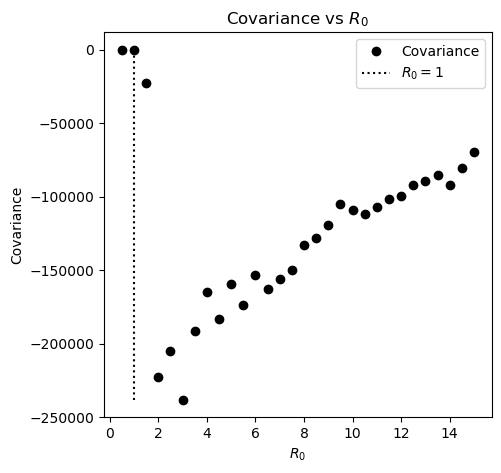

In [140]:
# plot covariance

plt.figure(figsize=(5,5))
plt.title('Covariance vs $R_0$')
plt.xlabel('$R_0$')
plt.ylabel('Covariance')
# plt.yscale('symlog')

covs = []
for ex in r0experiments.experiments:
    mean = ex.results.mean_result()
    covs.append(mean.s_i_covariance())
plt.plot(r0s, covs, 'ko', label='Covariance')
plt.vlines([1], ymin=min(covs), ymax=0, linestyles='dotted', colors='k', label='$R_0=1$')
plt.legend()
plt.show()

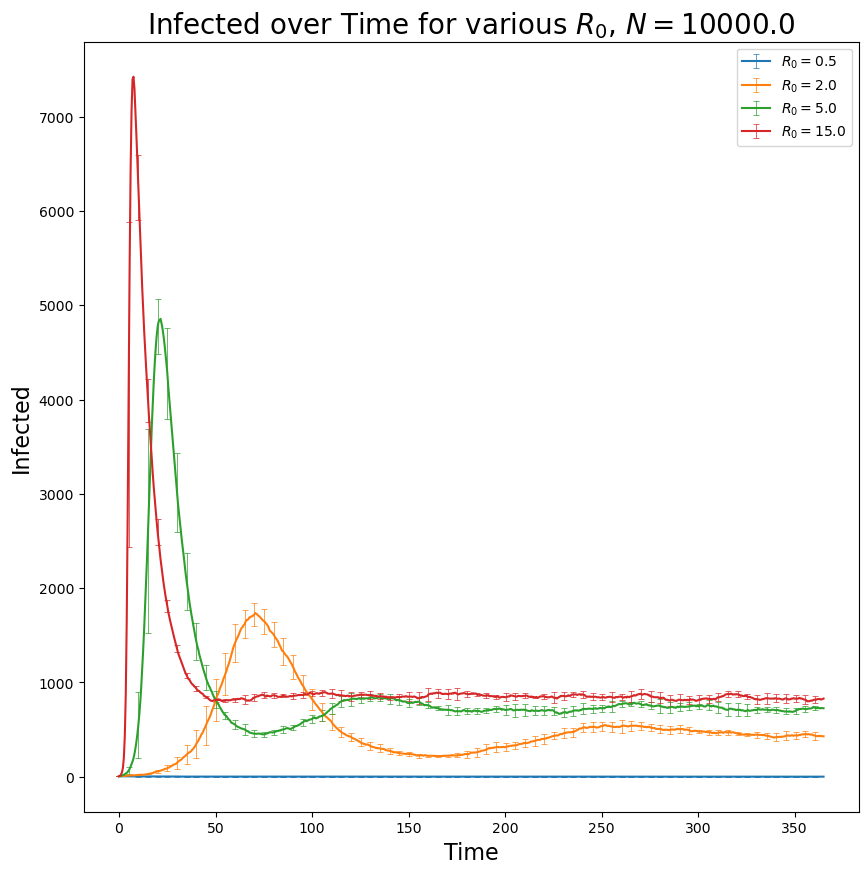

In [90]:
graphed_r0s = [0.5, 2.0, 5.0, 15.0]
plt.figure(figsize=(10, 10))
for ex in r0experiments.experiments:
    if ex.params.r0 not in graphed_r0s:
        continue
    mean, std = ex.results.mean_and_std_infected()
    plt.errorbar(ex.results.t, mean, yerr=std, errorevery=10, capsize=2, elinewidth=0.5, capthick=0.5, label=f"$R_0={ex.params.r0}$")
plt.xlabel("Time", fontsize=16)
plt.ylabel("Infected", fontsize=16)
plt.title(f'Infected over Time for various $R_0$, $N={population_size}$' , fontsize=20)
plt.legend()
plt.show()

### Varying $\gamma$

In [117]:
gammas = np.arange(0.05, 1.05, 0.05)
iterations = 5
r0 = 5.0

gamma_experiments = Experiments([])
for g in gammas:
    gamma_experiments.experiments.append(Experiment(Gillespie_Parameters(population_size, initial_infected, beta=beta, gamma=g, mu=mu), events, sim_length, data_rate, iterations))
gamma_experiments.run()

Running experiment: r0 = 8.33, beta = 0.5, gamma = 0.05, mu = 0.01, N = 10000.0, 5 iterations
Ran iteration 1 in 1.36 seconds
Ran iteration 2 in 1.29 seconds
Ran iteration 3 in 1.34 seconds
Ran iteration 4 in 1.36 seconds
Ran iteration 5 in 1.34 seconds
Running experiment: r0 = 4.55, beta = 0.5, gamma = 0.1, mu = 0.01, N = 10000.0, 5 iterations
Ran iteration 1 in 1.22 seconds
Ran iteration 2 in 1.30 seconds
Ran iteration 3 in 1.19 seconds
Ran iteration 4 in 1.28 seconds
Ran iteration 5 in 1.19 seconds
Running experiment: r0 = 3.12, beta = 0.5, gamma = 0.15000000000000002, mu = 0.01, N = 10000.0, 5 iterations
Ran iteration 1 in 1.18 seconds
Ran iteration 2 in 1.18 seconds
Ran iteration 3 in 1.17 seconds
Ran iteration 4 in 1.15 seconds
Ran iteration 5 in 1.14 seconds
Running experiment: r0 = 2.38, beta = 0.5, gamma = 0.2, mu = 0.01, N = 10000.0, 5 iterations
Ran iteration 1 in 1.09 seconds
Ran iteration 2 in 1.06 seconds
Ran iteration 3 in 1.09 seconds
Ran iteration 4 in 1.07 seconds
Ran

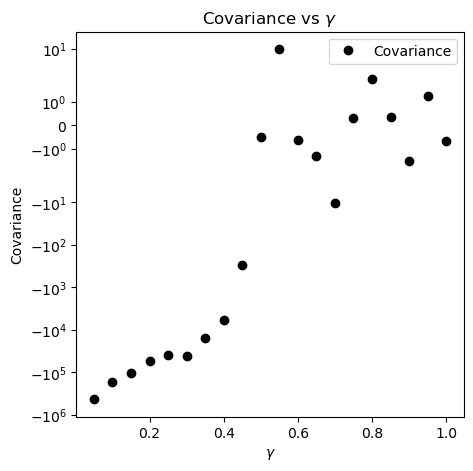

In [118]:
# plot covariance

plt.figure(figsize=(5,5))
plt.title('Covariance vs $\gamma$')
plt.xlabel('$\gamma$')
plt.ylabel('Covariance')
plt.yscale('symlog')

covs = []
for ex in gamma_experiments.experiments:
    mean = ex.results.mean_result()
    covs.append(mean.s_i_covariance())
plt.plot(gammas, covs, 'ko', label='Covariance')
plt.legend()
plt.show()

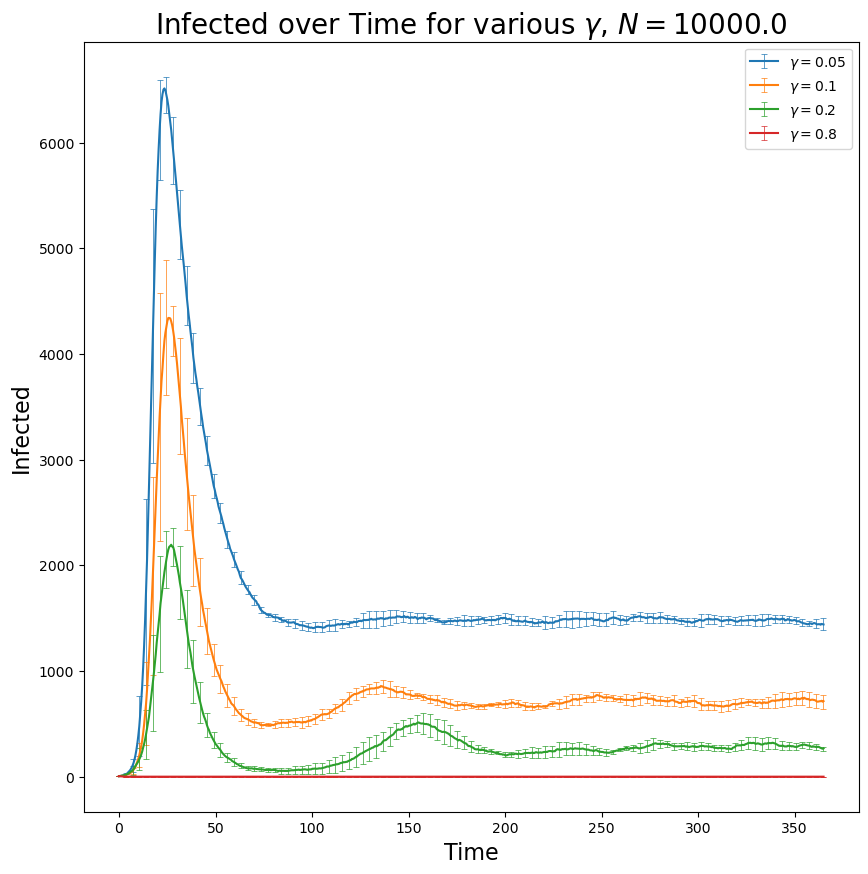

In [115]:
graphed_gammas = [0.05, 0.1, 0.2, 0.8]

plt.figure(figsize=(10, 10))
for ex in gamma_experiments.experiments:
    if ex.params.gamma not in graphed_gammas:
        continue
    mean, std = ex.results.mean_and_std_infected()
    plt.errorbar(ex.results.t, mean, yerr=std, errorevery=7, capsize=2, elinewidth=0.5, capthick=0.5, label=f"$\gamma={ex.params.gamma}$")
plt.xlabel("Time", fontsize=16)
plt.ylabel("Infected", fontsize=16)
plt.title(f'Infected over Time for various $\\gamma$, $N={population_size}$', fontsize=20)
plt.legend()
plt.show()

### Varying N

In [177]:
ns = [1e1, 1e2, 1e3, 1e4, 1e5]
iterations = 5
r0 = 5.0

n_experiments = Experiments([])
for n in ns:
    n_experiments.experiments.append(Experiment(Gillespie_Parameters(n, initial_infected, beta=beta, gamma=gamma, mu=mu), events, sim_length, data_rate, iterations))
n_experiments.run()

Running experiment: r0 = 4.55, beta = 0.5, gamma = 0.1, mu = 0.01, N = 10.0, 5 iterations
Extinction at t=49.841953242637345
Ran iteration 1 in 0.00 seconds
Extinction at t=33.53654013673265
Ran iteration 2 in 0.00 seconds
Extinction at t=19.962666707783026
Ran iteration 3 in 0.00 seconds
Extinction at t=14.37066057185027
Ran iteration 4 in 0.00 seconds
Extinction at t=27.911217325144538
Ran iteration 5 in 0.00 seconds
Running experiment: r0 = 4.55, beta = 0.5, gamma = 0.1, mu = 0.01, N = 100.0, 5 iterations
Extinction at t=52.60874740437048
Ran iteration 1 in 0.01 seconds
Extinction at t=74.95202604597881
Ran iteration 2 in 0.01 seconds
Extinction at t=215.6605143827031
Ran iteration 3 in 0.01 seconds
Extinction at t=272.7490583756671
Ran iteration 4 in 0.01 seconds
Extinction at t=66.77464475193383
Ran iteration 5 in 0.01 seconds
Running experiment: r0 = 4.55, beta = 0.5, gamma = 0.1, mu = 0.01, N = 1000.0, 5 iterations
Ran iteration 1 in 0.12 seconds
Ran iteration 2 in 0.14 seconds


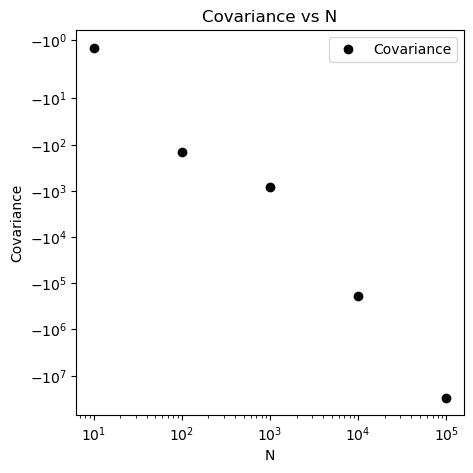

In [178]:
# plot covariance

plt.figure(figsize=(5,5))
plt.title('Covariance vs N')
plt.xlabel('N')
plt.ylabel('Covariance')
plt.yscale('symlog')
plt.xscale('log')

covs = []
for ex in n_experiments.experiments:
    mean = ex.results.mean_result()
    covs.append(mean.s_i_covariance())
plt.plot(ns, covs, 'ko', label='Covariance')
plt.legend()
plt.show()

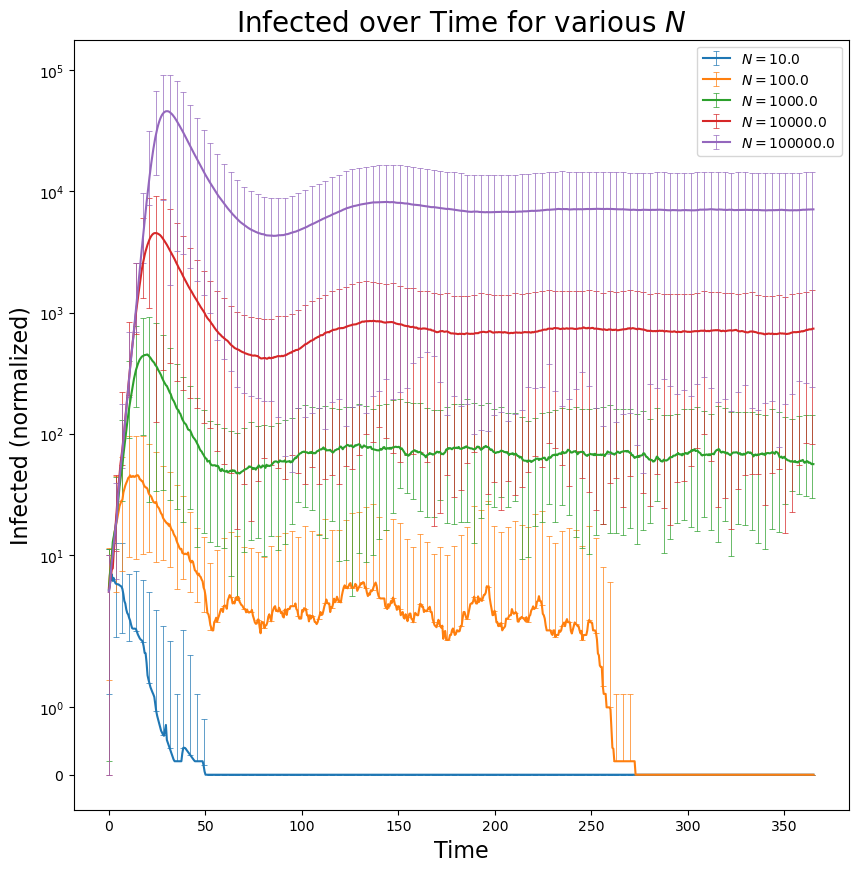

In [179]:
plt.figure(figsize=(10, 10))
plt.yscale('symlog')
for ex in n_experiments.experiments:
    mean, minmax = ex.results.mean_and_minmax_infected()
    plt.errorbar(ex.results.t, mean, yerr=minmax, errorevery=7, capsize=2, elinewidth=0.5, capthick=0.5, label=f"$N={ex.params.population.N()}$")
plt.xlabel("Time", fontsize=16)
plt.ylabel("Infected (normalized)", fontsize=16)
plt.title(f'Infected over Time for various $N$', fontsize=20)
plt.legend()
plt.show()